# Experiment

In [1]:

import numpy as np
import sys
from util import utility_functions

import logging
logging.basicConfig(stream=sys.stdout, format='%(asctime)s | %(name)s (%(levelname)s):\t %(message)s')

In [2]:
repitition_num = 1
parametrizations = utility_functions.get_parameterization_saps()
features = utility_functions.get_features_saps()
running_time = utility_functions.get_run_times_saps()

## Upper Confidence Bound (baseline)

In [ ]:
regret_ucb = np.zeros((repitition_num, features.shape[0]))
execution_time_ucb = np.zeros(repitition_num)

In [18]:
from algorithms import UCB
for rep in range(repitition_num):
    print(f"Rep no.: {rep + 1}")
    ucb = UCB(random_state=np.random.RandomState(515), parametrizations=parametrizations, features=features, running_time=running_time)
    ucb.run()
    regret_ucb[rep] = ucb.get_regret()
    execution_time_ucb[rep] = ucb.execution_time
    np.save('regret_UCB_saps_16', regret_ucb)

## CoLSTIM


In [3]:
regret_colstim = np.zeros((repitition_num, features.shape[0]))
execution_time_colstim = np.zeros(repitition_num)

In [ ]:
from algorithms import Colstim
for rep in range(repitition_num):
    print(f"Rep no.: {rep + 1}")
    colstim = Colstim(random_state=np.random.RandomState(515), parametrizations=parametrizations, features=features, running_time=running_time)
    colstim.run()
    regret_ucb[rep] = colstim.get_regret()
    execution_time_ucb[rep] = colstim.execution_time

### Colstim_v2

In [ ]:
from algorithms import Colstim_v2
for rep in range(repitition_num):
    print(f"Rep no.: {rep + 1}")
    colstim_v2 = Colstim_v2(random_state=np.random.RandomState(515), parametrizations=parametrizations, features=features, running_time=running_time)
    colstim_v2.run()
    regret_colstim[rep] = colstim_v2.get_regret()
    execution_time_colstim[rep] = colstim_v2.execution_time

# Plots

In [1]:
from util.constants import Solver
from util.metrics import compute_cumulative_regret
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_regret_curves(algorithms, solvers, subset_size, colors, directory, theta_0=False, single_solver=False):
    fig, ax = plt.subplots(len(solvers), len(subset_size), figsize=(30, 7), constrained_layout=True)
    for solver_index, solver in enumerate(solvers):
        for size_index, size in enumerate(subset_size):
            for index, algorithm in enumerate(algorithms):
                regret = np.load(f"{directory}//regret_{algorithm}_{solver}_{size}.npy", allow_pickle=True)
                cum_reg = compute_cumulative_regret(regret)
                if not single_solver:
                    ax[solver_index, size_index].plot(np.log(np.mean(cum_reg, axis=0)), color=colors[index], label=f"{algorithm}")
                    # ax[solver_index, size_index].fill_between(
                    #     range(len(cum_reg[0])), 
                    #     np.log(np.mean(cum_reg, axis=0)-np.std(cum_reg, axis=0))/np.sqrt(len(cum_reg)), 
                    #     np.log(np.mean(cum_reg, axis=0)+np.std(cum_reg, axis=0))/np.sqrt(len(cum_reg)), 
                    #     color=colors[index],
                    #     alpha=0.2
                    # )
                    ax[solver_index, size_index].legend()
                    ax[solver_index, size_index].set_ylabel("Logarithmic Cumulative Regret")
                    ax[solver_index, size_index].set_xlabel("Time")
                    ax[solver_index, size_index].set_title(f"N: 20, Solver: {solver}, Subset Size: {size}")
                else:
                    ax[size_index].plot(np.log(np.mean(cum_reg, axis=0)), color=colors[index], label=f"{algorithm}")
                    # ax[size_index].fill_between(
                    #     range(len(cum_reg[0])), 
                    #     np.log(np.mean(cum_reg, axis=0)-np.std(cum_reg, axis=0))/np.sqrt(len(cum_reg)), 
                    #     np.log(np.mean(cum_reg, axis=0)+np.std(cum_reg, axis=0))/np.sqrt(len(cum_reg)), 
                    #     color=colors[index],
                    #     alpha=0.2
                    # )
                    ax[size_index].legend()
                    ax[size_index].set_ylabel("Logarithmic Cumulative Regret")
                    ax[size_index].set_xlabel("Time")
                    ax[size_index].set_title(f"N: 20, Solver: {solver}, Subset Size: {size}")
    if theta_0:
        fig.suptitle('Logarithmic Cumulative regrets with initial theta = 0', fontsize=16)
    else:
        fig.suptitle('Logarithmic Cumulative regrets with random initial theta', fontsize=16)
    plt.show()

    fig, ax = plt.subplots(len(solvers), len(subset_size), figsize=(30, 7), constrained_layout=True)
    for solver_index, solver in enumerate(solvers):
        for size_index, size in enumerate(subset_size):
            for index, algorithm in enumerate(algorithms):
                regret = np.load(f"{directory}//regret_{algorithm}_{solver}_{size}.npy", allow_pickle=True)
                cum_reg = compute_cumulative_regret(regret)
                if not single_solver:
                    ax[solver_index, size_index].plot(np.mean(cum_reg, axis=0), color=colors[index], label=f"{algorithm}")
                    # ax[solver_index, size_index].fill_between(
                    #     range(len(cum_reg[0])), 
                    #     np.log(np.mean(cum_reg, axis=0)-np.std(cum_reg, axis=0))/np.sqrt(len(cum_reg)), 
                    #     np.log(np.mean(cum_reg, axis=0)+np.std(cum_reg, axis=0))/np.sqrt(len(cum_reg)), 
                    #     color=colors[index],
                    #     alpha=0.2
                    # )
                    ax[solver_index, size_index].legend()
                    ax[solver_index, size_index].set_ylabel("Cumulative Regret")
                    ax[solver_index, size_index].set_xlabel("Time")
                    ax[solver_index, size_index].set_title(f"N: 20, Solver: {solver}, Subset Size: {size}")
                else:
                    ax[size_index].plot(np.mean(cum_reg, axis=0), color=colors[index], label=f"{algorithm}")
                    # ax[size_index].fill_between(
                    #     range(len(cum_reg[0])), 
                    #     np.log(np.mean(cum_reg, axis=0)-np.std(cum_reg, axis=0))/np.sqrt(len(cum_reg)), 
                    #     np.log(np.mean(cum_reg, axis=0)+np.std(cum_reg, axis=0))/np.sqrt(len(cum_reg)), 
                    #     color=colors[index],
                    #     alpha=0.2
                    # )
                    ax[size_index].legend()
                    ax[size_index].set_ylabel("Cumulative Regret")
                    ax[size_index].set_xlabel("Time")
                    ax[size_index].set_title(f"N: 20, Solver: {solver}, Subset Size: {size}")
    if theta_0:
        fig.suptitle('Cumulative regrets with initial theta = 0', fontsize=16)
    else:
        fig.suptitle('Cumulative regrets with random initial theta', fontsize=16)
    plt.show()  

def plot_execution_times(algorithms, solvers, subset_size, colors, directory, single_solver=False):
    fig, ax = plt.subplots(len(solvers), len(subset_size), figsize=(30, 7), constrained_layout=True)
    if not single_solver:
        for solver_index, solver in enumerate(solvers):
            for size_index, size in enumerate(subset_size):
                for index, algorithm in enumerate(algorithms):
                    execution_time = np.load(f"{directory}//execution_time_{algorithm}_{solver}_{size}.npy")
                    ax[solver_index, size_index].bar(x=algorithm, height=execution_time.mean(), color=colors[index], label=f"{algorithm}")
                # ax[solver_index, size_index].fill_between(
                #     range(len(cum_reg[0])), 
                #     np.log(np.mean(cum_reg, axis=0)-np.std(cum_reg, axis=0))/np.sqrt(len(cum_reg)), 
                #     np.log(np.mean(cum_reg, axis=0)+np.std(cum_reg, axis=0))/np.sqrt(len(cum_reg)), 
                #     color=colors[index],
                #     alpha=0.2
                # )
                    ax[solver_index, size_index].legend()
                    ax[solver_index, size_index].set_ylabel("Mean execution time")
                    ax[solver_index, size_index].set_xlabel("Algorithms")
                    ax[solver_index, size_index].set_title(f"Solver: {solver}, Subset Size: {size}")
                ax[solver_index, size_index].grid()
    else:
        for solver_index, solver in enumerate(solvers):
            for size_index, size in enumerate(subset_size):
                for index, algorithm in enumerate(algorithms):
                    execution_time = np.load(f"{directory}//execution_time_{algorithm}_{solver}_{size}.npy")
                    ax[size_index].bar(x=algorithm, height=execution_time.mean(), color=colors[index], label=f"{algorithm}")
                # ax[size_index].fill_between(
                #     range(len(cum_reg[0])), 
                #     np.log(np.mean(cum_reg, axis=0)-np.std(cum_reg, axis=0))/np.sqrt(len(cum_reg)), 
                #     np.log(np.mean(cum_reg, axis=0)+np.std(cum_reg, axis=0))/np.sqrt(len(cum_reg)), 
                #     color=colors[index],
                #     alpha=0.2
                # )
                    ax[size_index].legend()
                    ax[size_index].set_ylabel("Mean execution time")
                    ax[size_index].set_xlabel("Algorithms")
                    ax[size_index].set_title(f"Solver: {solver}, Subset Size: {size}")
                ax[size_index].grid()
    plt.show()

## Plot Regrets from Regret_results

/tmp/ipykernel_26616/1609391087.py:15: RuntimeWarning: divide by zero encountered in log
  ax[solver_index, size_index].plot(np.log(np.mean(cum_reg, axis=0)), color=colors[index], label=f"{algorithm}")


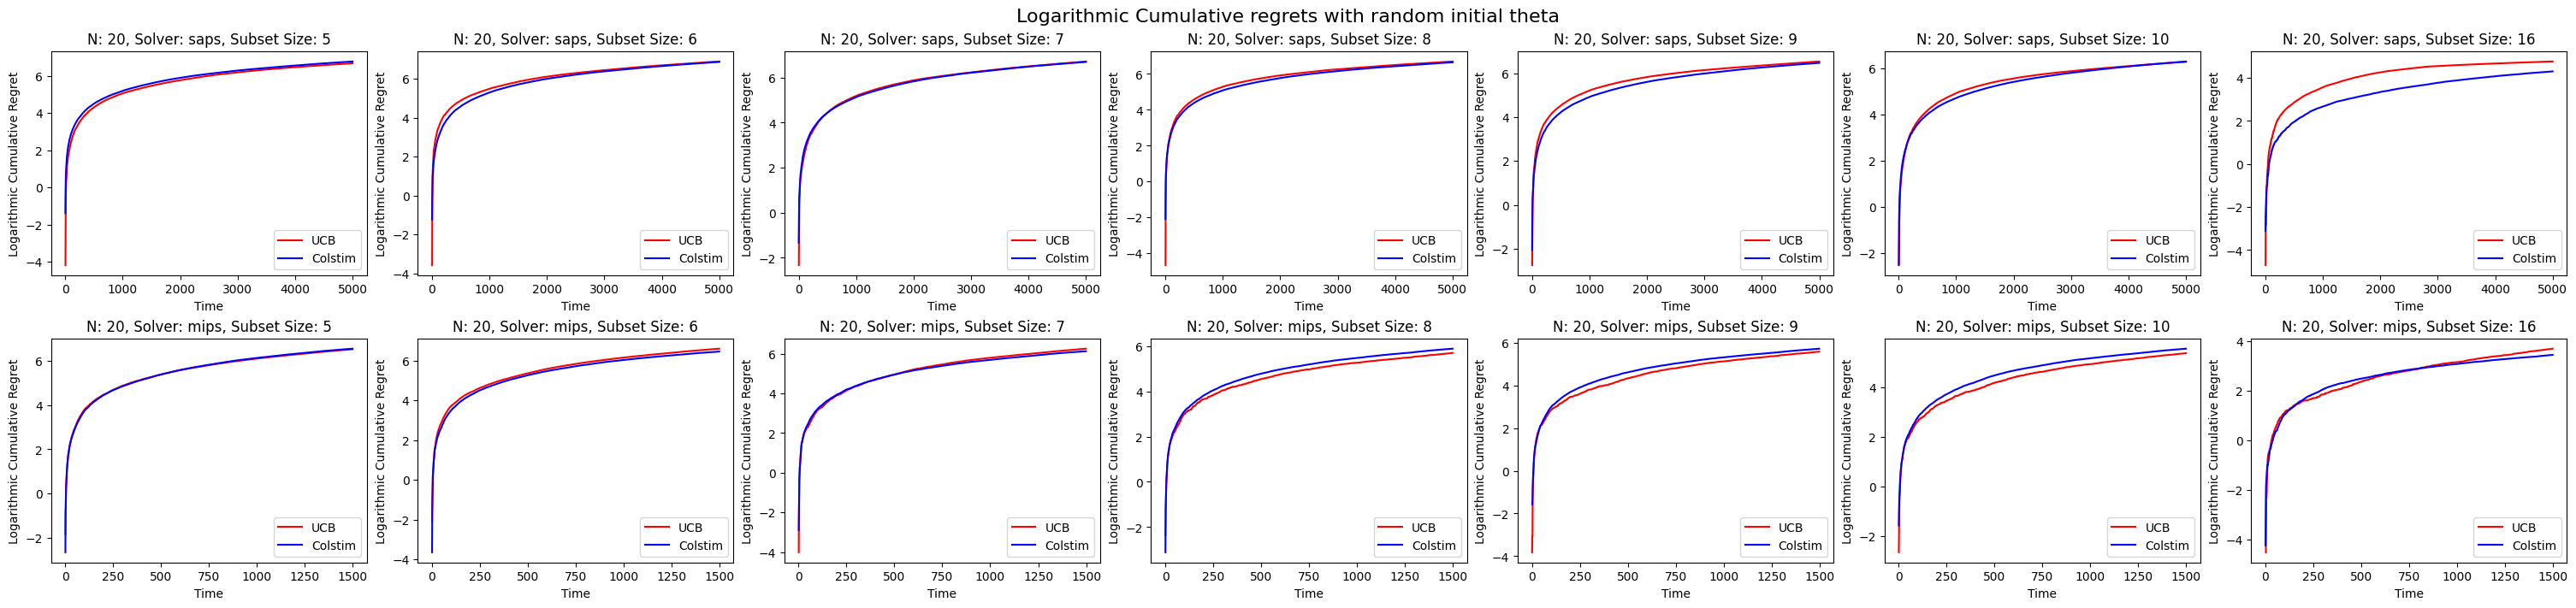

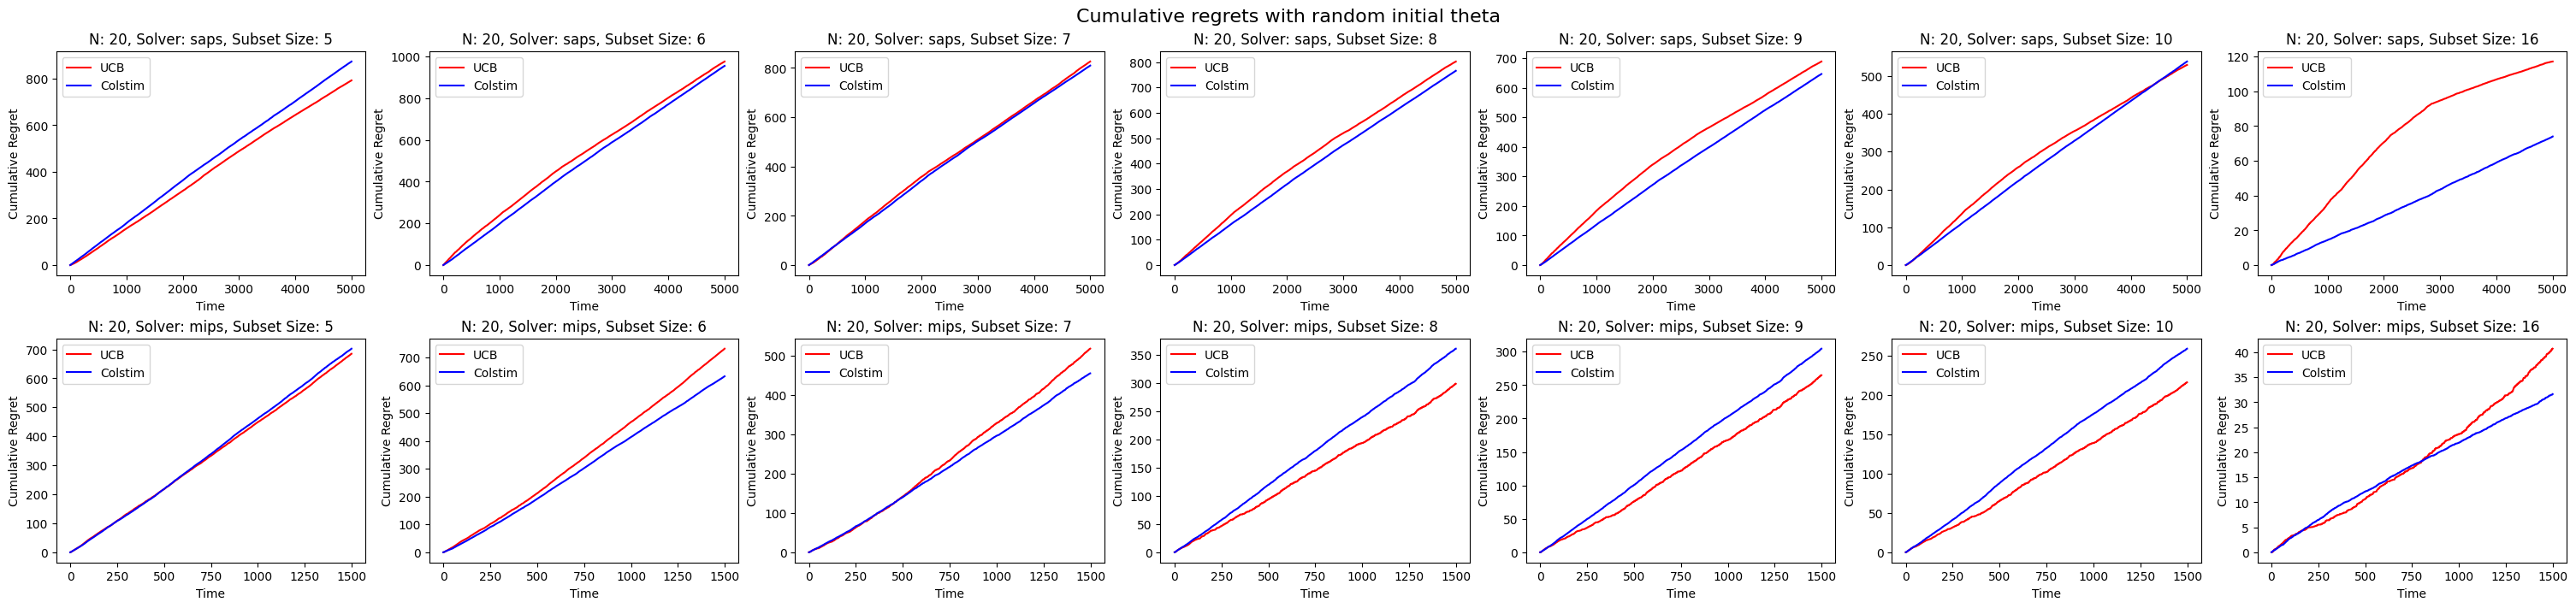

In [2]:
algorithms = ["UCB", "Colstim"]
solvers = [solver.value for solver in Solver]
subset_size = [5, 6, 7, 8, 9, 10, 16]
colors = ["red", "blue"]
directory = "Regret_results"
plot_regret_curves(algorithms, solvers, subset_size, colors, directory)

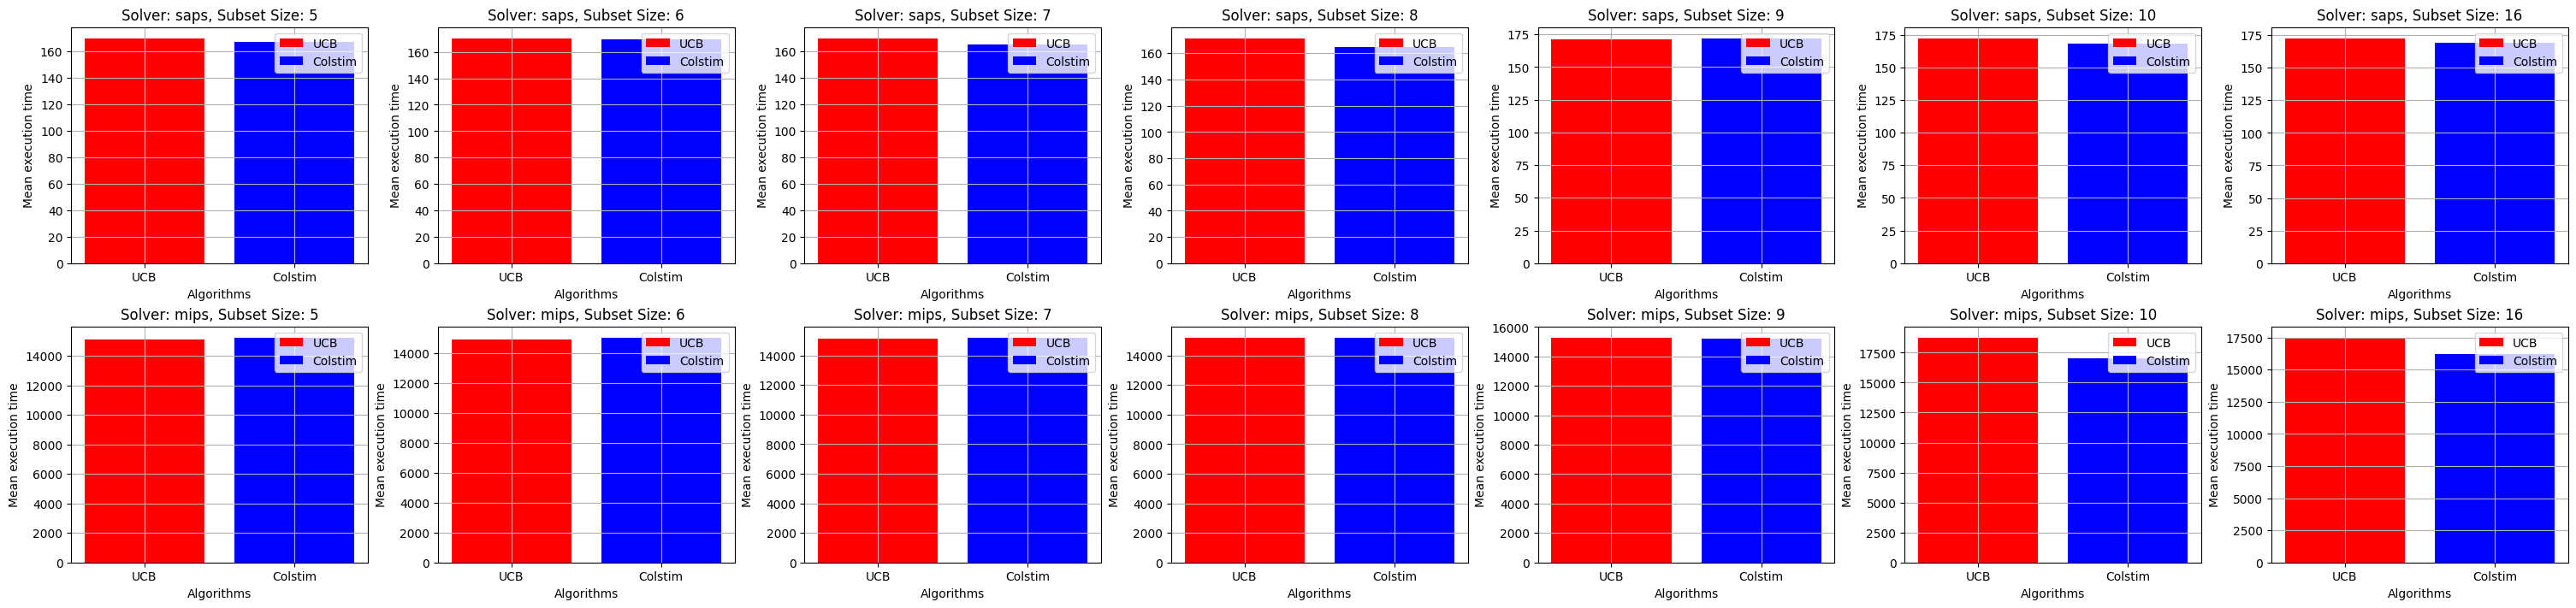

In [3]:
directory = "Execution_times_results"
plot_execution_times(algorithms, solvers, subset_size, colors, directory)

## Plotting results from Theta0

/tmp/ipykernel_26616/1609391087.py:15: RuntimeWarning: divide by zero encountered in log
  ax[solver_index, size_index].plot(np.log(np.mean(cum_reg, axis=0)), color=colors[index], label=f"{algorithm}")


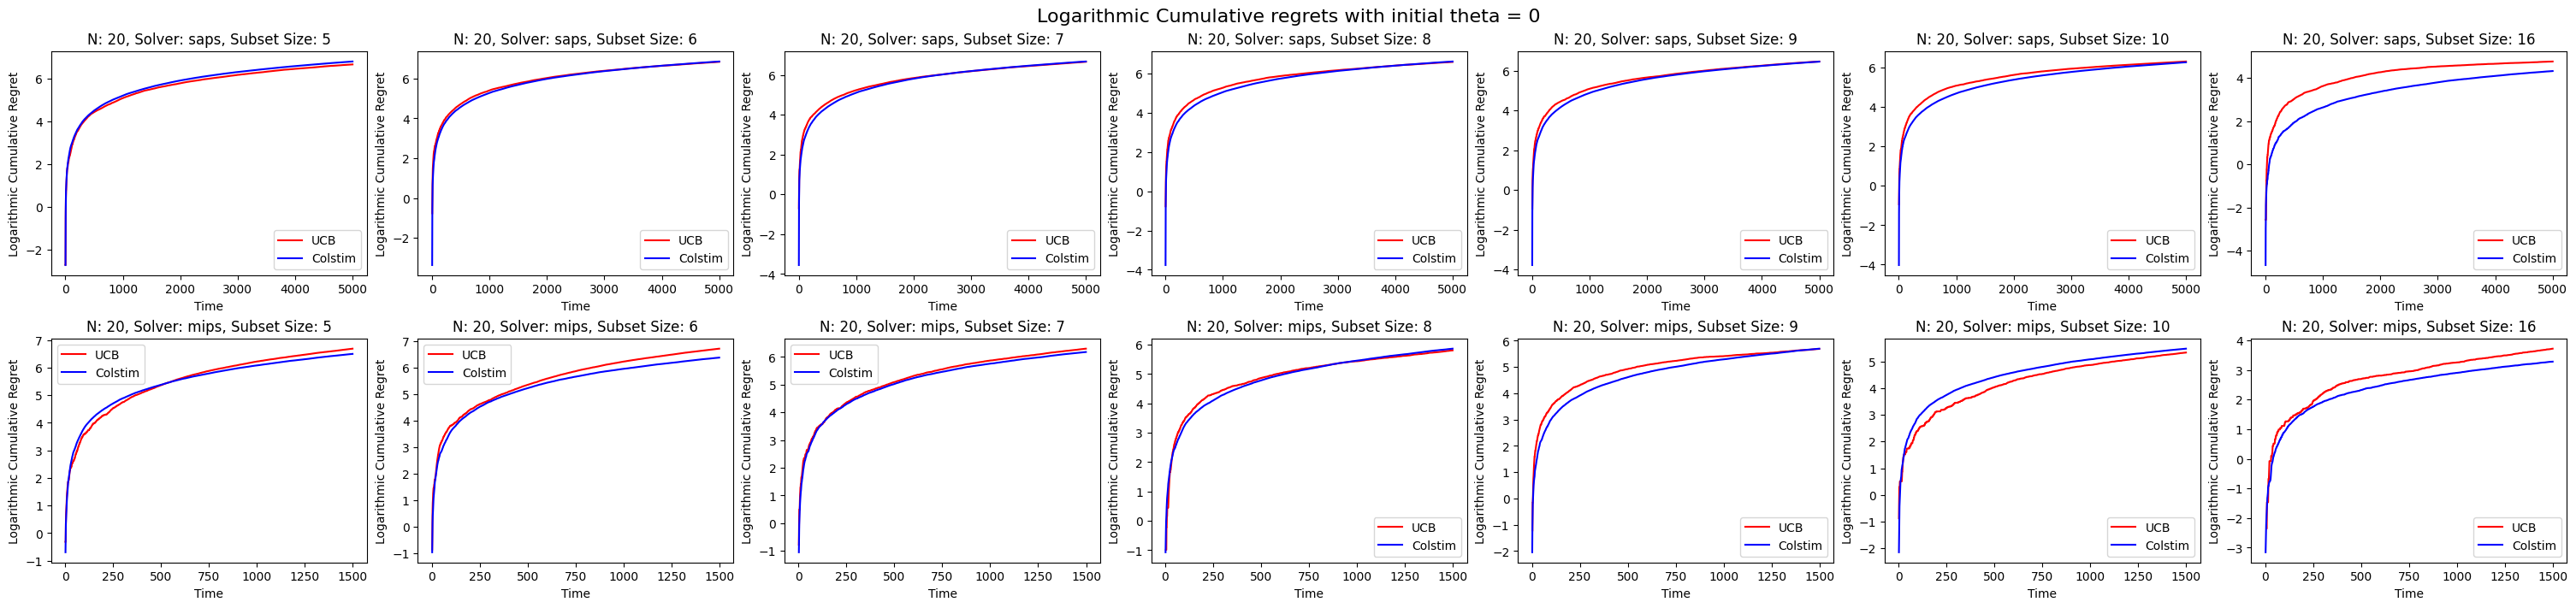

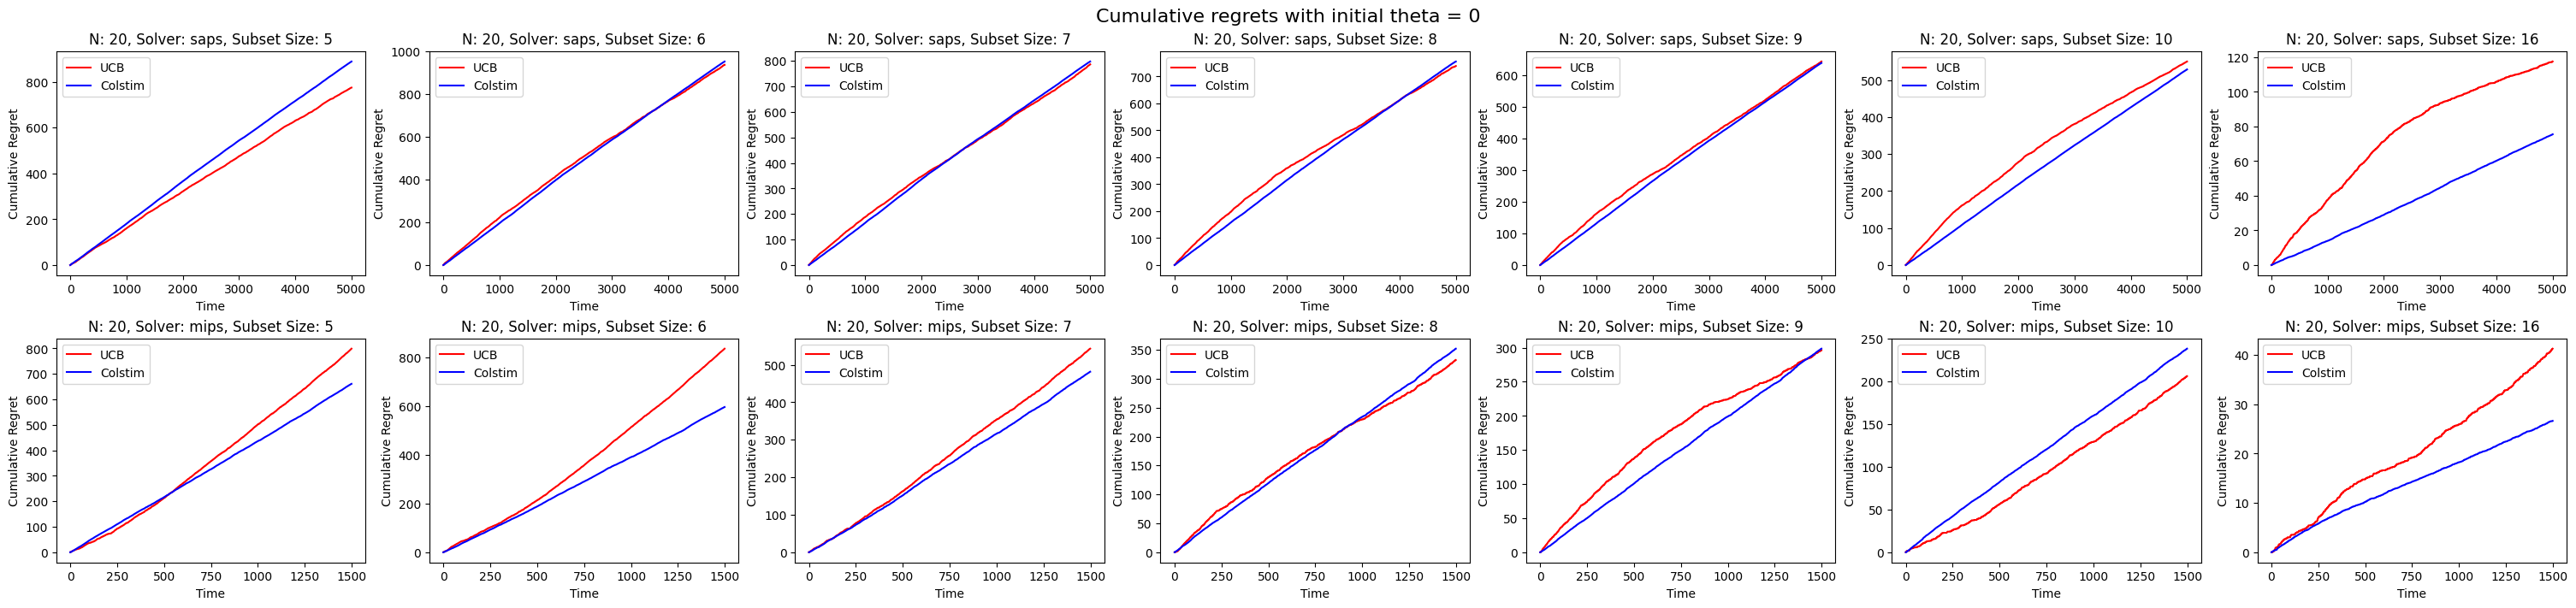

In [4]:
algorithms = ["UCB", "Colstim"]
solvers = [solver.value for solver in Solver]
subset_size = [5, 6, 7, 8, 9, 10, 16]
colors = ["red", "blue"]
directory = "Regret_results_theta0"
plot_regret_curves(algorithms, solvers, subset_size, colors, directory, theta_0=True)

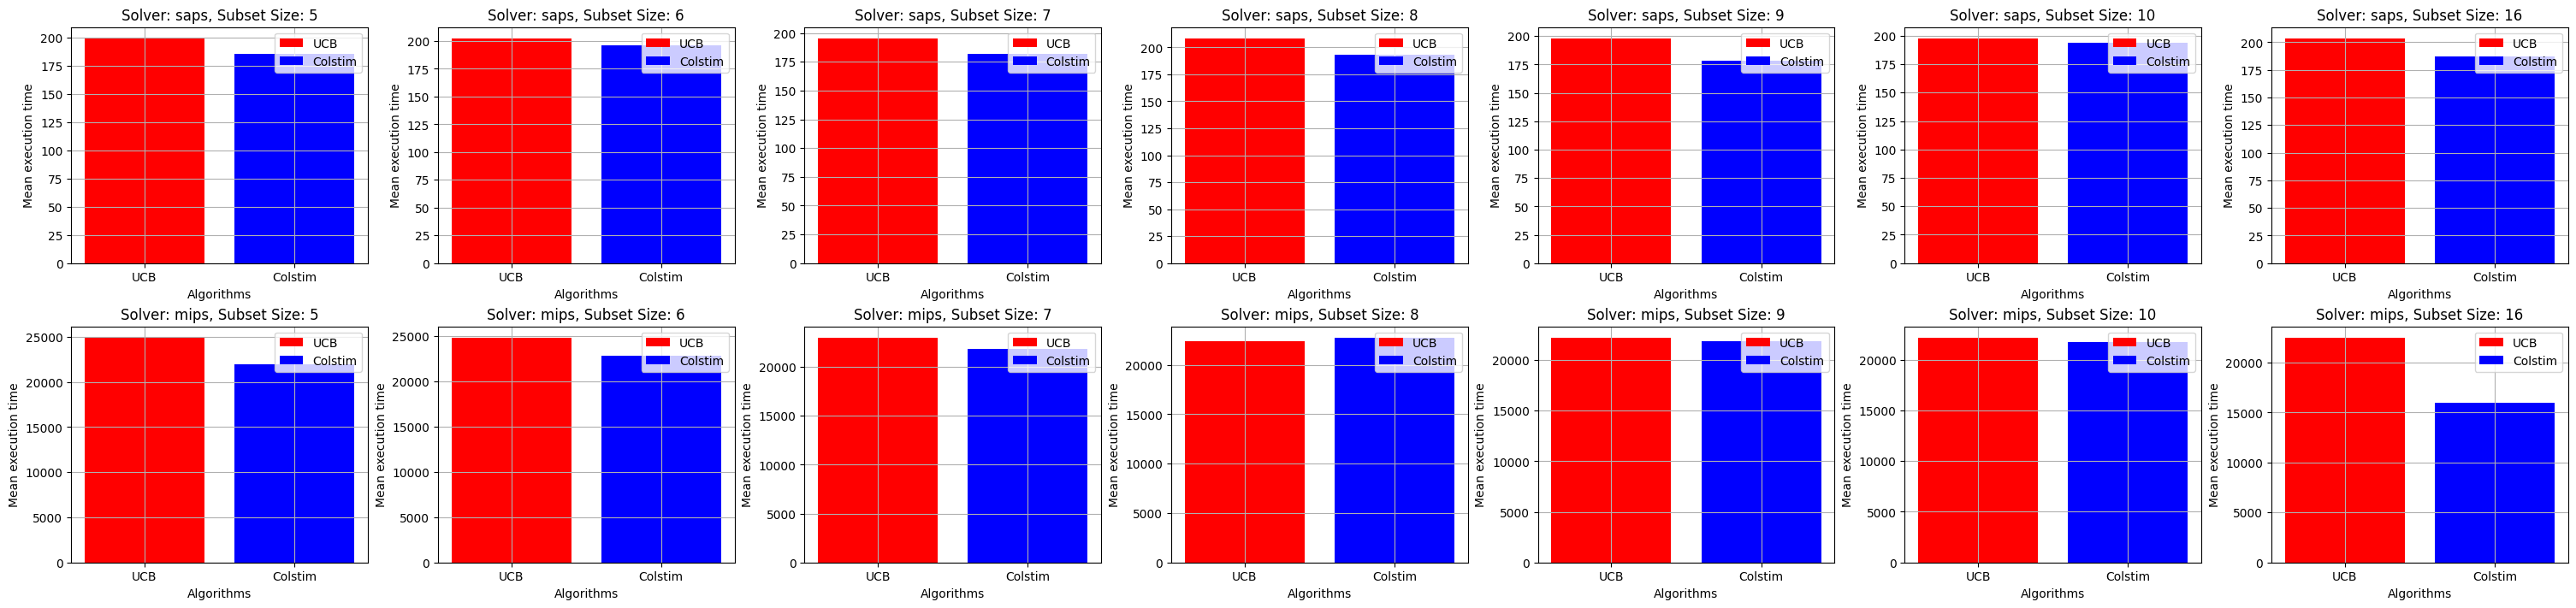

In [5]:
directory = "Execution_times_results_theta0"
plot_execution_times(algorithms, solvers, subset_size, colors, directory)

## Plotting Colstim V2 with theta0

/tmp/ipykernel_66446/1609391087.py:15: RuntimeWarning: divide by zero encountered in log
  ax[solver_index, size_index].plot(np.log(np.mean(cum_reg, axis=0)), color=colors[index], label=f"{algorithm}")


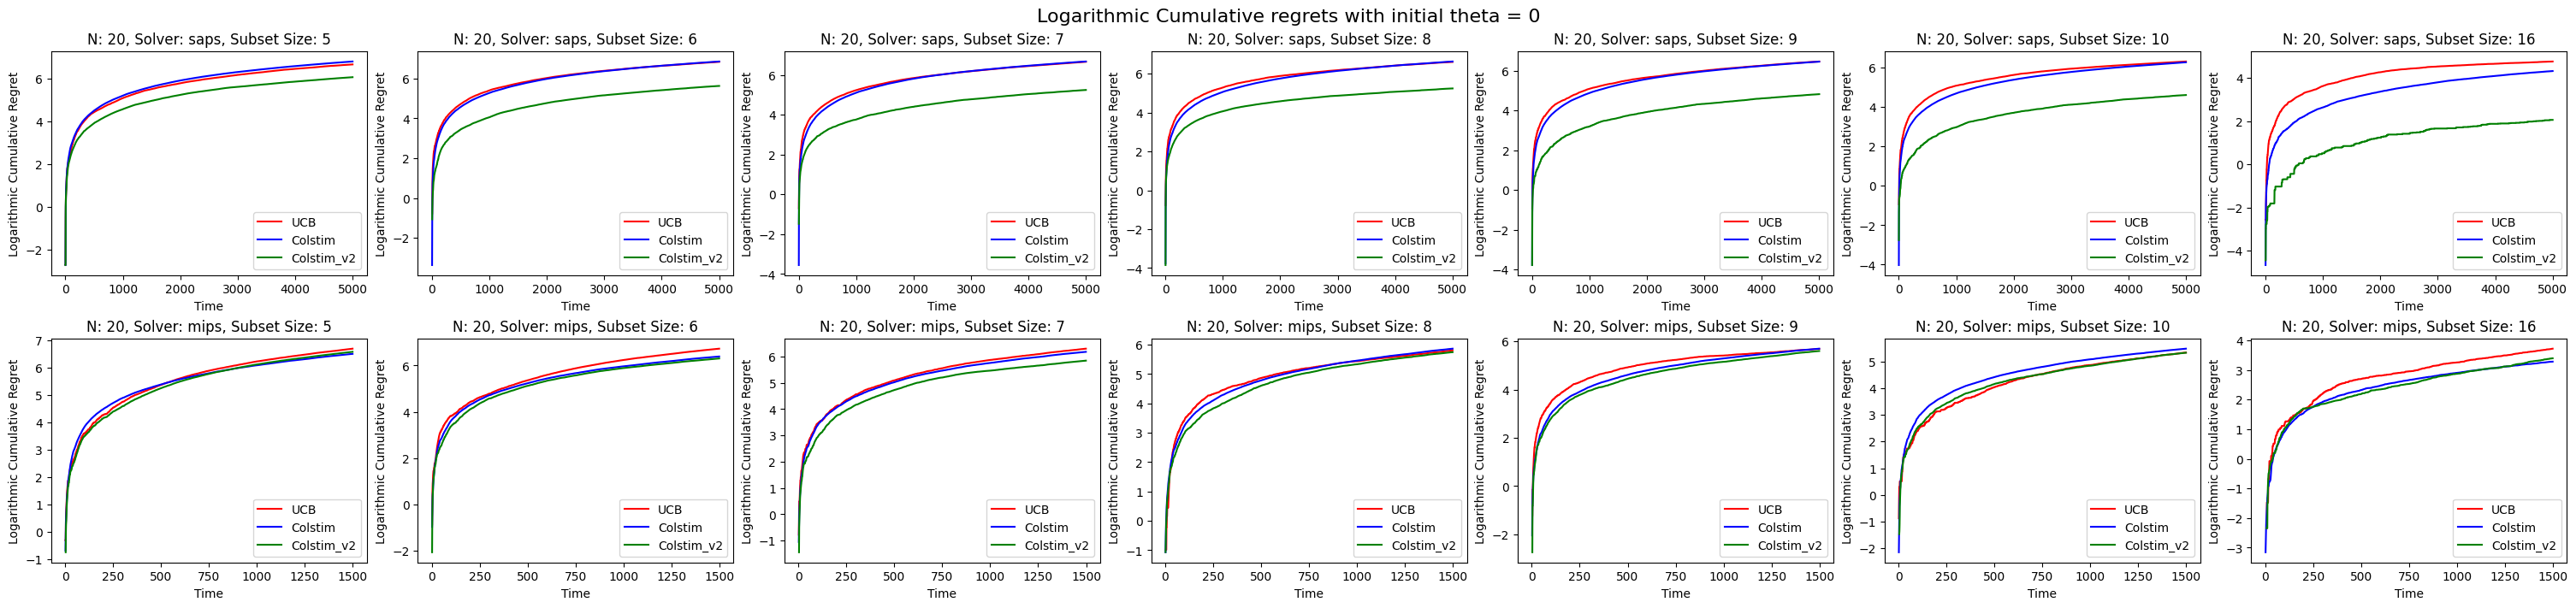

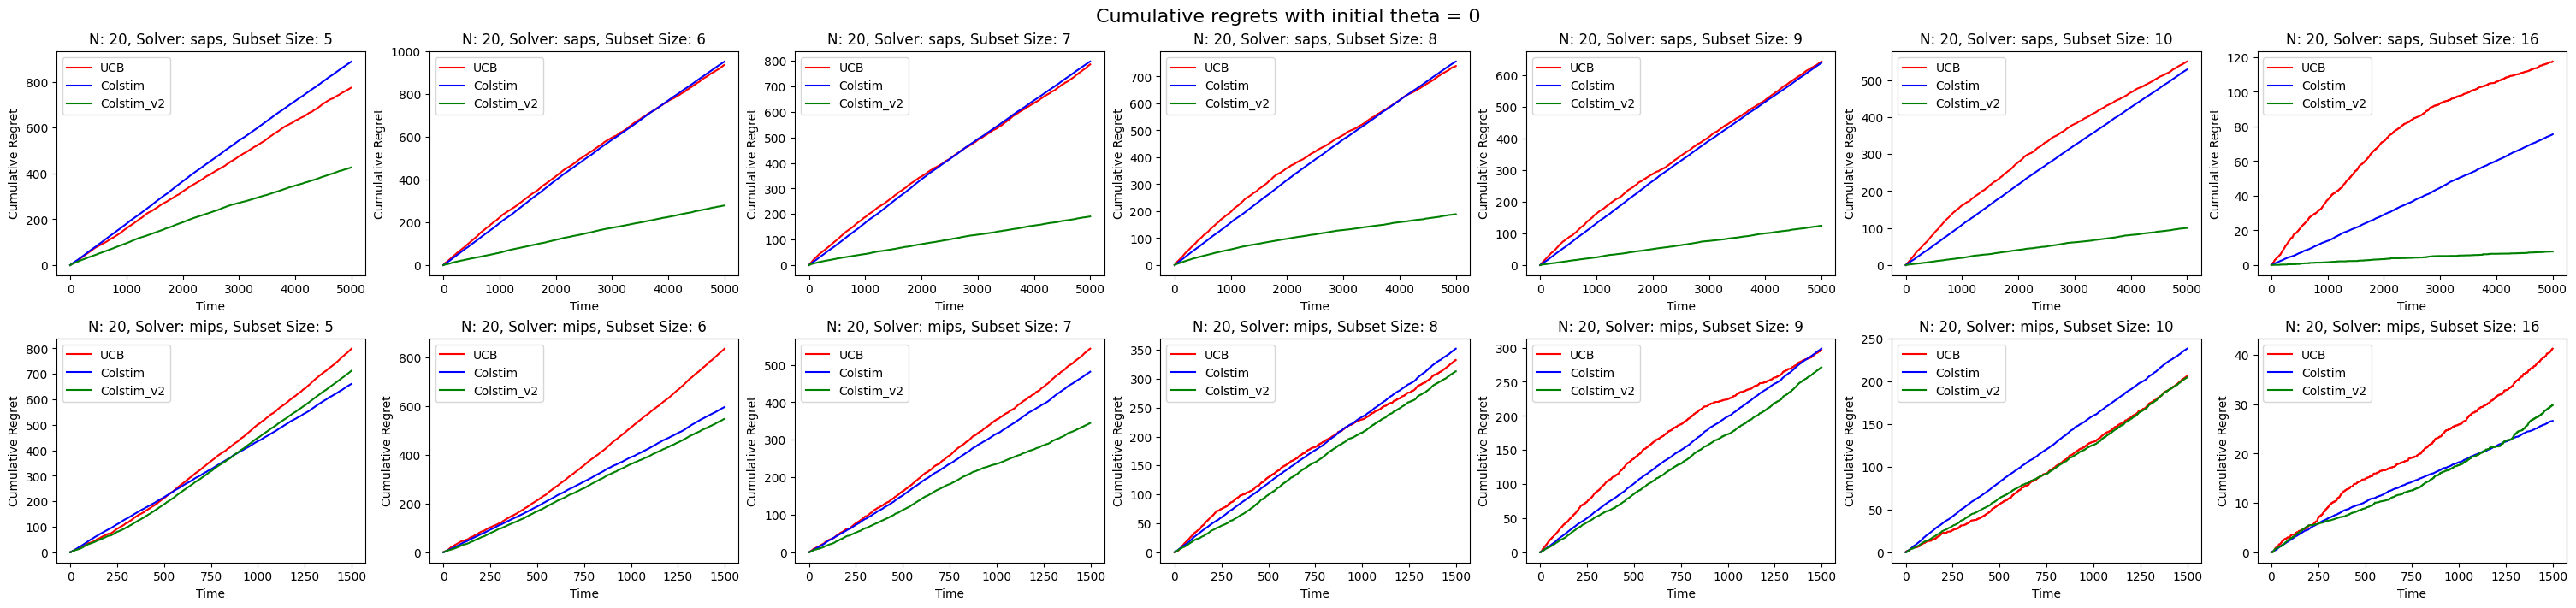

In [10]:
from algorithms import regret_minimizing_algorithms
    
algorithms = [algorithm.__name__ for algorithm in regret_minimizing_algorithms]

solvers = [solver.value for solver in Solver]
subset_size = [5, 6, 7, 8, 9, 10, 16]
colors = ["red", "blue", "green"]
directory = "Regret_results_theta0"
plot_regret_curves(algorithms, solvers, subset_size, colors, directory, theta_0=True)

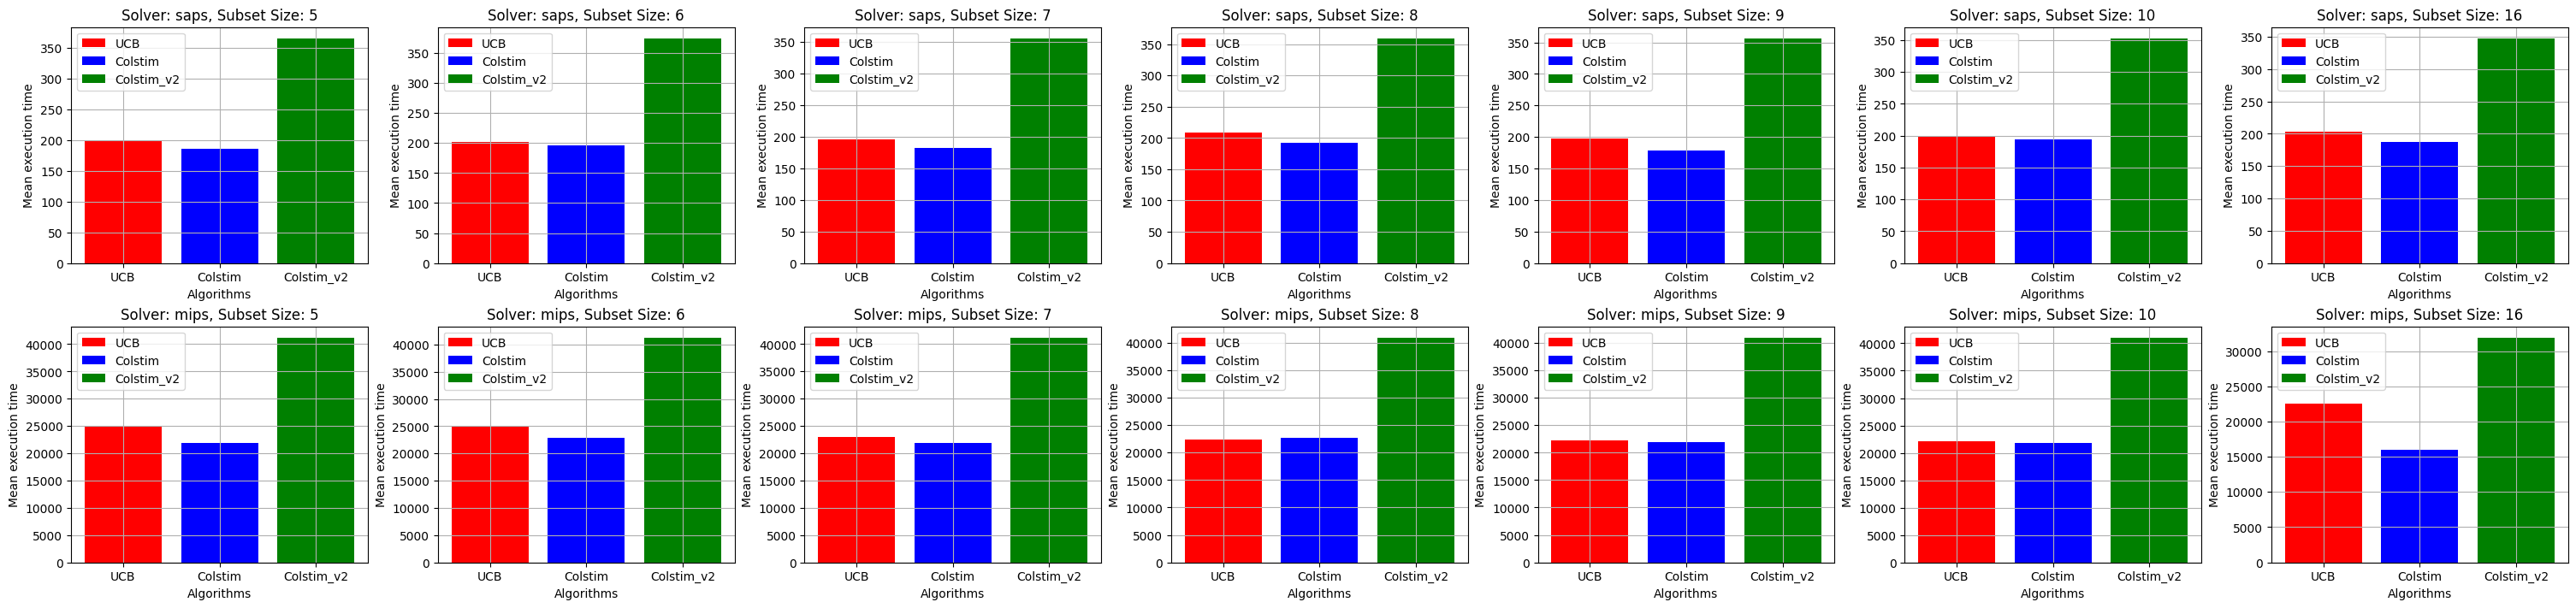

In [12]:
directory = "Execution_times_results_theta0"
plot_execution_times(algorithms, solvers, subset_size, colors, directory)

## Plotting 50 reps

/tmp/ipykernel_76341/1609391087.py:28: RuntimeWarning: divide by zero encountered in log
  ax[size_index].plot(np.log(np.mean(cum_reg, axis=0)), color=colors[index], label=f"{algorithm}")


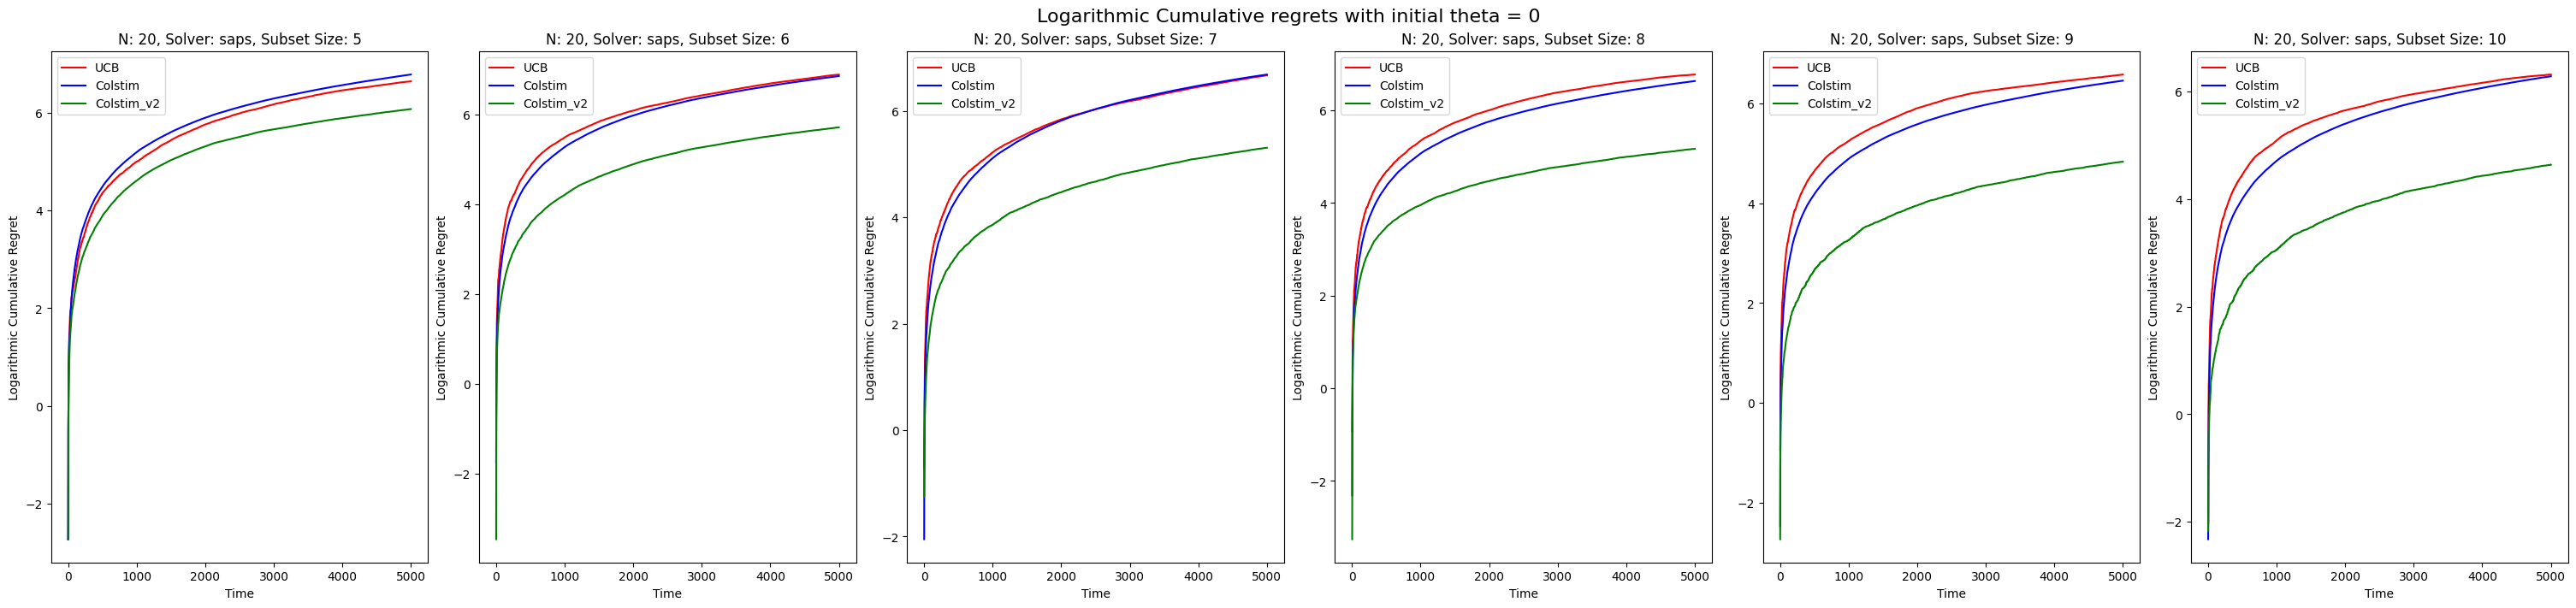

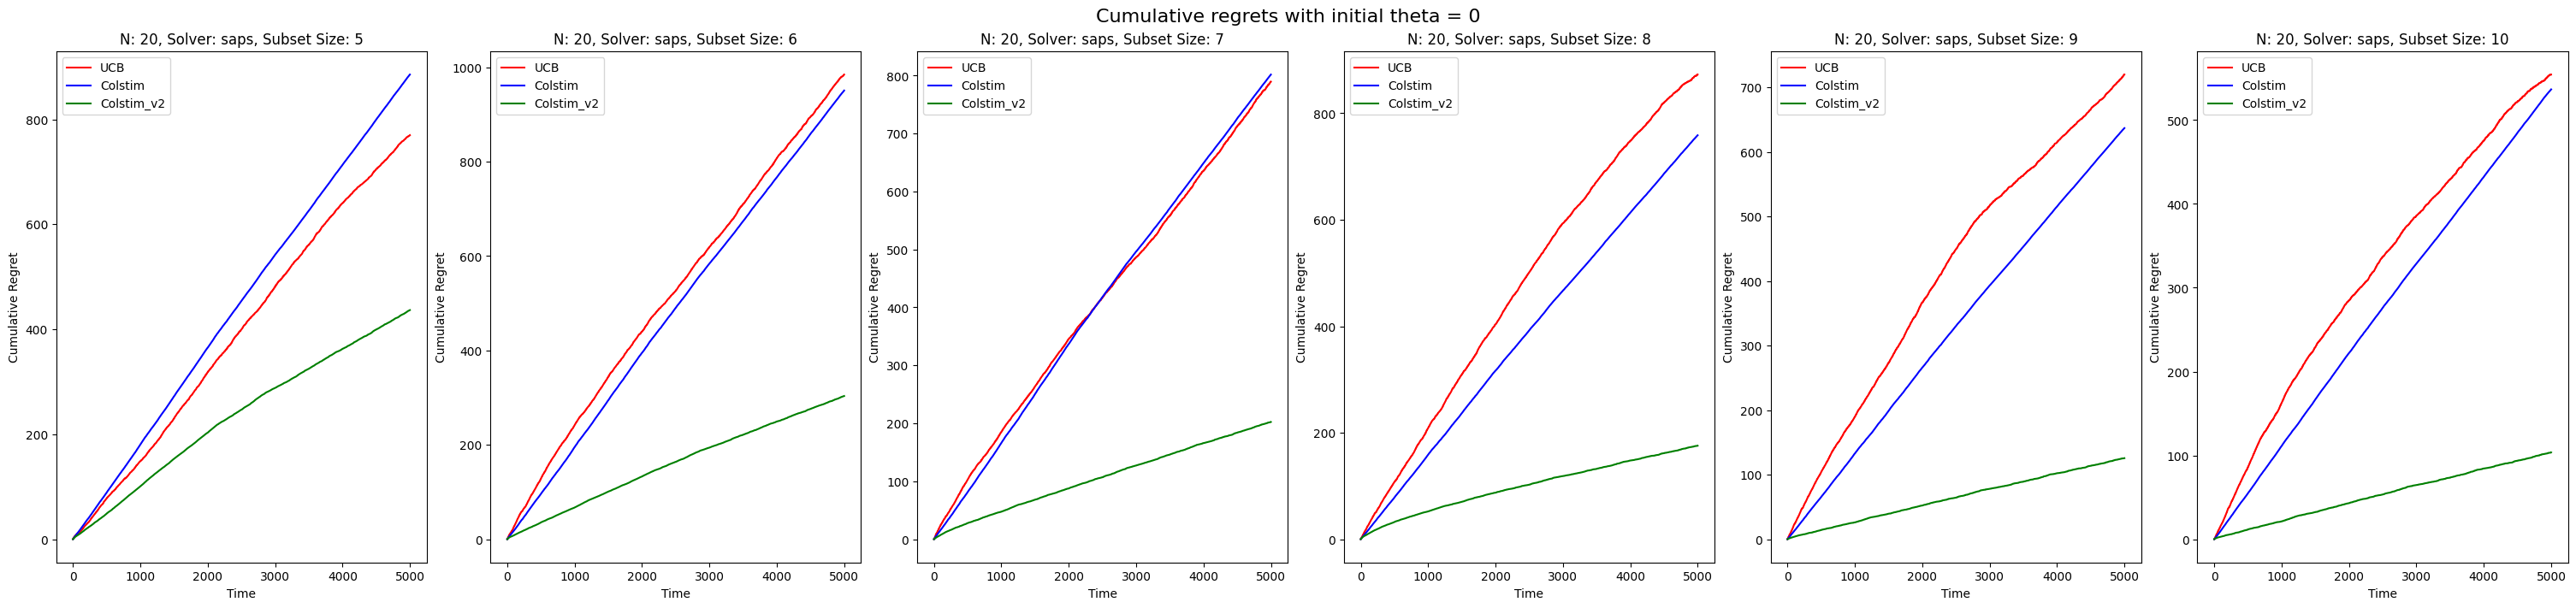

In [4]:
from algorithms import regret_minimizing_algorithms
    
algorithms = [algorithm.__name__ for algorithm in regret_minimizing_algorithms]

solvers = [Solver.SAPS.value]
subset_size = [5, 6, 7, 8, 9, 10]
colors = ["red", "blue", "green"]
directory = "Regret_results_theta0_50"
plot_regret_curves(algorithms, solvers, subset_size, colors, directory, theta_0=True, single_solver=True)

## Concatenate rep of MIPS dataset

In [5]:
for size in [5, 6, 7, 8, 9, 10, 16]:
    execution_time = np.load(f"Execution_times_results_v2/execution_time_Colstim_v2_mips_{size}.npy", allow_pickle=True)
    execution_time_2 = np.load(f"Execution_times_results_v2/execution_time_Colstim_v2_mips_{size}_2.npy", allow_pickle=True)
    execution_time_3 = np.load(f"Execution_times_results_v2/execution_time_Colstim_v2_mips_{size}_3.npy", allow_pickle=True)  
    execution_time_4 = np.load(f"Execution_times_results_v2/execution_time_Colstim_v2_mips_{size}_4.npy", allow_pickle=True)  
    execution_time_con = np.concatenate((execution_time, execution_time_2, execution_time_3, execution_time_4))
    np.save(f"Execution_times_results_v2//execution_time_Colstim_v2_mips_{size}.npy", execution_time_con)

In [8]:
np.load("Execution_times_results_theta0/execution_time_Colstim_v2_mips_5.npy", allow_pickle=True)

array([28246.47454369, 28202.42160515, 28312.66955276, 46781.16721135,
       46801.01410709, 46809.08650008, 46688.39425993, 46576.94707812,
       46793.11589472, 46811.15779342])